#### Importamos las librerías

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#### Almacenamos nuestra tabla en un Dataframe

In [149]:
# Importamos el dataframe con la columna "deposit" incluida
df_bank = pd.read_csv("perfil_cliente_mysql.csv", delimiter=";")

# Creamos un segundo dataframe sin la columna "deposit" para el algoritmo
df_kmeans = df_bank.drop(columns=["deposit"])

#### Vamos a convertir las categorías de trabajo en 3 subgrupos: Profesional, Manual y Otro

In [150]:
job_mapping = {
    "admin": "profesional",
    "technician": "profesional",
    "management": "profesional",
    "entrepreneur": "profesional",
    "self-employed": "profesional",
    "blue-collar": "manual",
    "services": "manual",
    "housemaid": "manual",
    "retired": "otro",
    "unemployed": "otro",
    "student": "otro",
    "unknown": "otro"
}

df_kmeans['job'] = df_kmeans['job'].replace(job_mapping)

print(df_kmeans['job'].value_counts())

job
profesional    9372
manual         4525
otro           2266
Name: count, dtype: int64


#### Preprocesamiento variables categóricas

In [151]:
categorical_features = ["job", "marital", "education", "default", "housing", "loan"]

label_encoders = {}

for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    
    df_kmeans[feature + "_encoded"] = label_encoders[feature].fit_transform(df_kmeans[feature])

df_kmeans = df_kmeans.drop(columns=categorical_features, axis=1)

df_kmeans

,age,balance,job_encoded,marital_encoded,education_encoded,default_encoded,housing_encoded,loan_encoded
0,59,2343,2,1,1,0,1,0
1,59,2343,2,1,1,0,1,0
2,56,45,2,1,1,0,0,0
3,41,1270,2,1,1,0,1,0
4,55,2476,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...
16158,26,1595,2,1,1,0,0,0
16159,37,1967,2,1,1,0,0,0
16160,45,81,2,1,2,0,0,1
16161,44,618,0,2,1,0,0,0


#### Preprocesamiento variables numéricas

<Figure size 800x500 with 0 Axes>

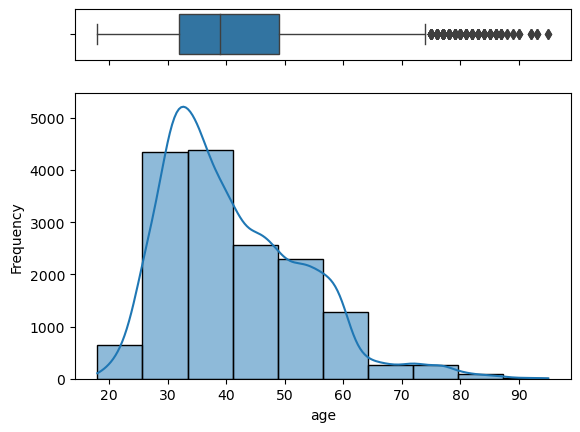

<Figure size 800x500 with 0 Axes>

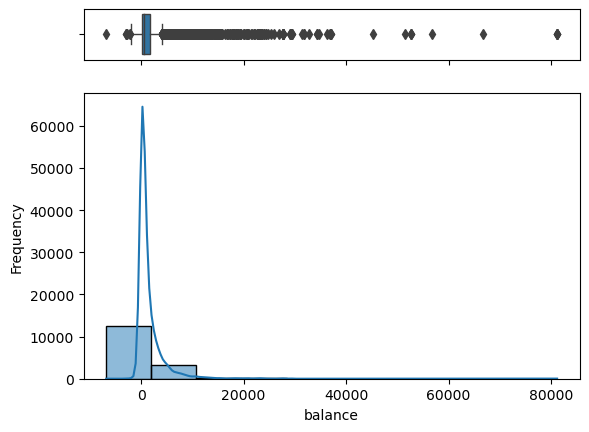

In [152]:
numerical_features = ["age", "balance"]

for i in numerical_features:
    plt.figure(figsize=(8, 5))
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    sns.boxplot(x=df_kmeans[i], orient="h", ax=ax_box, linewidth=1.0)
    
    sns.histplot(df_kmeans[i], ax=ax_hist, bins=10, kde=True)
    
    ax_box.set(xlabel='')
    ax_hist.set(xlabel=i)
    
    plt.gca().set(xlabel= i,ylabel='Frequency')

#### Como las variables tienen outliers, vamos a utilizar los límites superiores e inferiores del IQR para reemplazarlos.

In [153]:
def percentile_calculation(df, column):
    percentile_75 = df[column].quantile(0.75)
    percentile_25 = df[column].quantile(0.25)
    IQR = percentile_75 - percentile_25
    upper_limit = percentile_75 + (1.5 * IQR)
    lower_limit = percentile_25 - (1.5 * IQR)
    return upper_limit, lower_limit

def winsorize_percentile(df, column):
    upper_limit, lower_limit = percentile_calculation(df, column)

    print(f'upper limit de {column}: {upper_limit}')
    print(f'lower limit de {column}: {lower_limit}')
    
    df[column] = np.where(df[column] > upper_limit, upper_limit,
                          np.where(df[column] < lower_limit, lower_limit, df[column]))
    return df


for i in numerical_features:
    df_kmeans = winsorize_percentile(df_kmeans, i)


upper limit de age: 74.5
lower limit de age: 6.5
upper limit de balance: 4108.0
lower limit de balance: -2268.0


<Figure size 800x500 with 0 Axes>

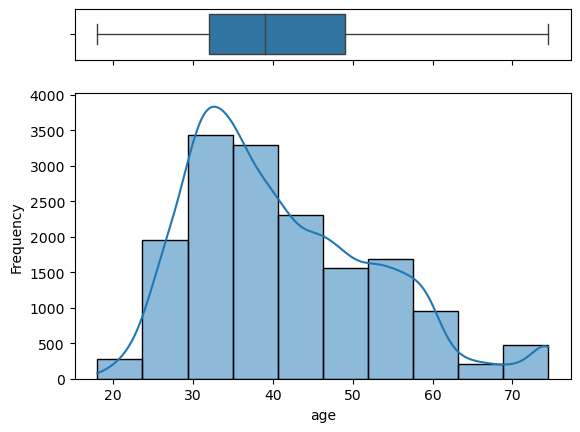

<Figure size 800x500 with 0 Axes>

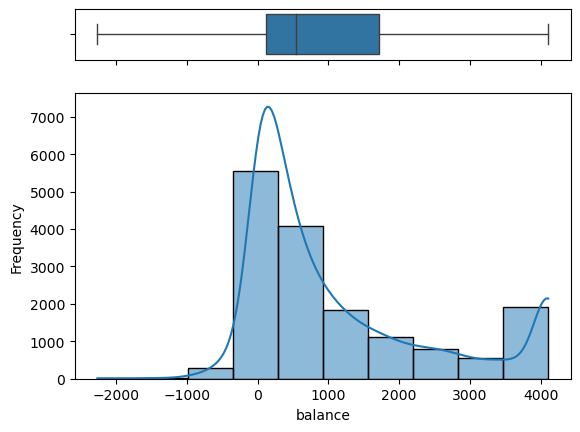

In [154]:
for i in numerical_features:
    plt.figure(figsize=(8, 5))
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    sns.boxplot(x=df_kmeans[i], orient="h", ax=ax_box, linewidth=1.0)
    
    sns.histplot(df_kmeans[i], ax=ax_hist, bins=10, kde=True)
    
    ax_box.set(xlabel='')
    ax_hist.set(xlabel=i)
    
    plt.gca().set(xlabel= i,ylabel='Frequency')

In [155]:
scaler = StandardScaler()

df_kmeans[numerical_features] = scaler.fit_transform(df_kmeans[numerical_features])

df_kmeans

,age,balance,job_encoded,marital_encoded,education_encoded,default_encoded,housing_encoded,loan_encoded
0,1.523529,0.902923,2,1,1,0,1,0
1,1.523529,0.902923,2,1,1,0,1,0
2,1.267015,-0.793012,2,1,1,0,0,0
3,-0.015556,0.111044,2,1,1,0,1,0
4,1.181510,1.001078,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...
16158,-1.298126,0.350896,2,1,1,0,0,0
16159,-0.357574,0.625434,2,1,1,0,0,0
16160,0.326463,-0.766444,2,1,2,0,0,1
16161,0.240958,-0.370135,0,2,1,0,0,0


#### Luego de estandarizar, veamos la distribución con media 0 y desviación estándar de 1.

<Figure size 800x500 with 0 Axes>

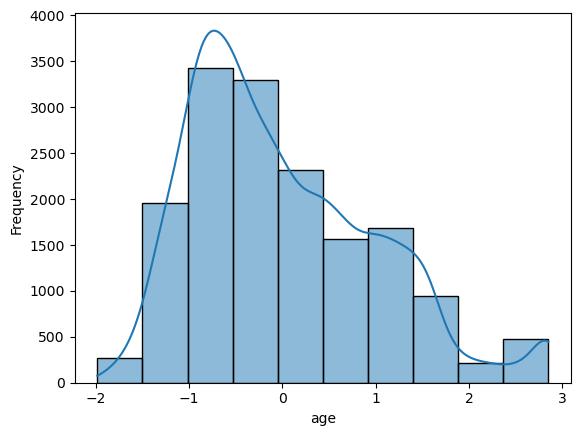

<Figure size 800x500 with 0 Axes>

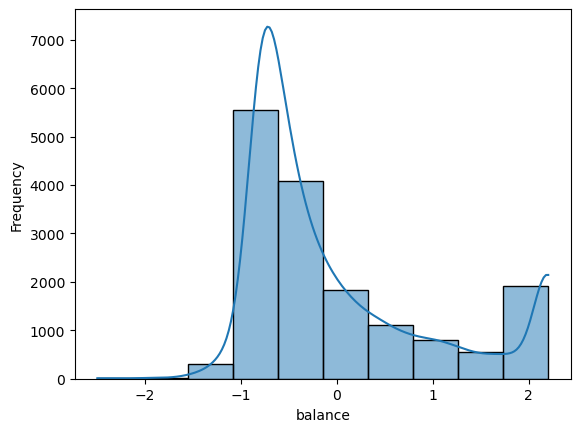

In [156]:
for i in numerical_features:
    plt.figure(figsize=(8, 5))
    
    f, ax = plt.subplots(sharex=True)
    
    sns.histplot(df_kmeans[i], bins=10, kde=True)
    
    ax_hist.set(xlabel=i)
    
    plt.gca().set(xlabel= i,ylabel='Frequency')

#### Identificamos el número de clusters

c:\Users\damim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\damim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\damim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\damim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

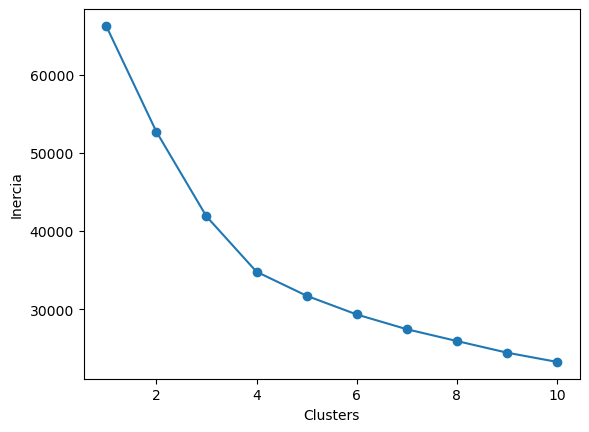

In [157]:
# Lista para almacenar la inercia para cada K
inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_kmeans)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Clusters')
plt.ylabel('Inercia')
plt.show()

#### Ejecutamos el algoritmo de K-Means con 4 clusters

In [158]:
kmeans = KMeans(n_clusters=4, random_state=42)

df_kmeans['cluster'] = kmeans.fit_predict(df_kmeans)

c:\Users\damim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [159]:
score = silhouette_score(df_kmeans, df_kmeans['cluster'])
print(f'Silhouette Score: {score}')

Silhouette Score: 0.3497323052540778


In [168]:
# Para poder unificar las tablas, cambiamos el título de las columnas age y balance
df_kmeans = df_kmeans.rename(columns={"age": "age_kmeans", "balance": "balance_kmeans"})

# Y luego realizamos un join a través del índice

df_results = df_kmeans.join(df_bank)

df_results

,age_kmeans,balance_kmeans,cluster,job_original,marital_original,education_original,default_original,housing_original,loan_original,age,job,marital,education,default,balance,housing,loan,deposit
0,1.523529,0.902923,1,profesional,married,secondary,no,yes,no,59,admin,married,secondary,no,2343,yes,no,yes
1,1.523529,0.902923,1,profesional,married,secondary,no,yes,no,59,admin,married,secondary,no,2343,yes,no,yes
2,1.267015,-0.793012,1,profesional,married,secondary,no,no,no,56,admin,married,secondary,no,45,no,no,yes
3,-0.015556,0.111044,0,profesional,married,secondary,no,yes,no,41,technician,married,secondary,no,1270,yes,no,yes
4,1.181510,1.001078,2,manual,married,secondary,no,yes,no,55,services,married,secondary,no,2476,yes,no,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16158,-1.298126,0.350896,0,profesional,married,secondary,no,no,no,26,admin,married,secondary,no,1595,no,no,yes
16159,-0.357574,0.625434,0,profesional,married,secondary,no,no,no,37,admin,married,secondary,no,1967,no,no,yes
16160,0.326463,-0.766444,0,profesional,married,tertiary,no,no,yes,45,management,married,tertiary,no,81,no,yes,no
16161,0.240958,-0.370135,2,manual,single,secondary,no,no,no,44,services,single,secondary,no,618,no,no,yes


#### Graficamos las variables categóricas

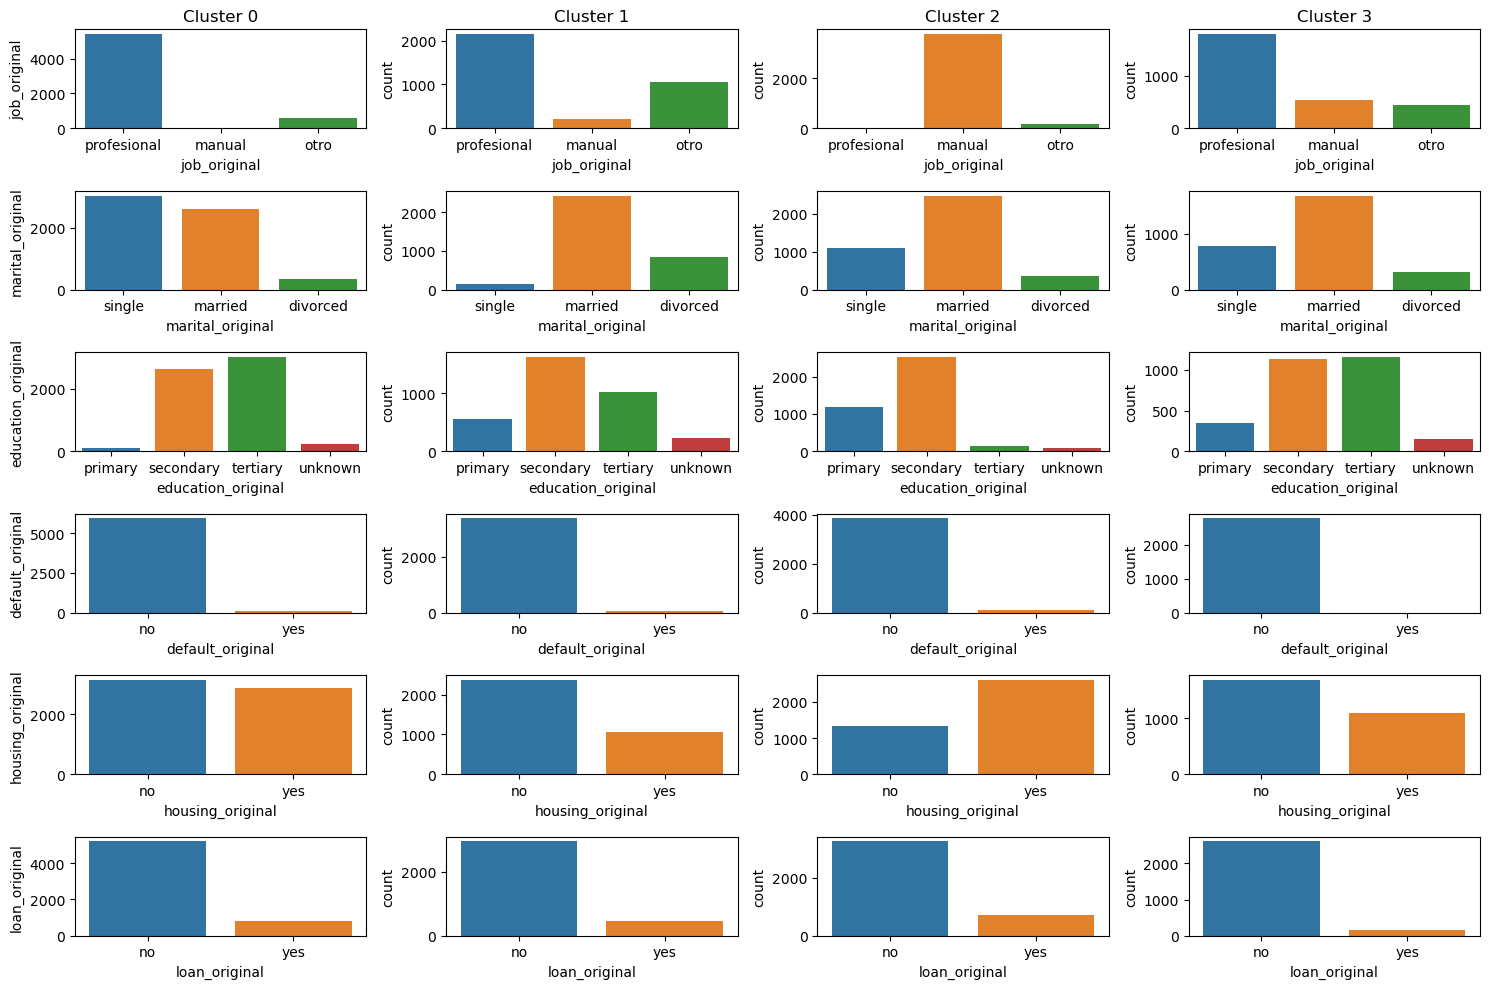

In [161]:
categorical_features = ["job","marital","education", "default", "housing", "loan"]

clusters = sorted(df_results['cluster'].unique())

fig, axes = plt.subplots(nrows=len(categorical_features), ncols=len(clusters), figsize=(15, 10), sharey=False)

category_orders = {
    'job': ['profesional', 'manual', 'otro'],
    'marital': ['single', 'married', 'divorced'],
    'education': ['primary', 'secondary', 'tertiary', 'unknown'],
    'default': ['no', 'yes'],
    'housing': ['no', 'yes'],
    'loan': ['no', 'yes']
}

for row, feature in enumerate(categorical_features):
    for col, cluster in enumerate(clusters):
        cluster_data = df_kmeans[df_kmeans['cluster'] == cluster]
        
        sns.countplot(data=cluster_data, x=feature, ax=axes[row, col], order=category_orders[feature])
        
        if row == 0:
            axes[row, col].set_title(f'Cluster {cluster}')
        if col == 0:
            axes[row, col].set_ylabel(feature)

plt.tight_layout()
plt.show()